In [1]:
import sys
import os
import subprocess
import os
import numpy as np
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path+"/detectors")
from detectors import Body, render_from_candidate_and_subset

In [14]:
suffix_cpp_result = ".cpp.pose.bmp"
suffix_py_result = ".py.pose.bmp"

def find_image_files(directory):
    image_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                image_files.append(os.path.join(root, file))
    return image_files

def convert_path(input_path, suffix):
    dir_name = os.path.dirname(input_path)
    base_name = os.path.basename(input_path)

    new_dir = os.path.join(dir_name, 'output')
    base_name_without_ext = os.path.splitext(base_name)[0]
    new_base_name = base_name_without_ext + suffix
    new_path = os.path.join(new_dir, new_base_name)

    return new_path
    
def run_command(input_file):
    # 运行子命令并返回 stdout 和 stderr
    command = ["../build/Release/detectors_bridge.exe", "-i", input_file, "-o", convert_path(input_file, suffix_cpp_result), "-m" ,"../model"]
    result = subprocess.run(command, capture_output=True, text=True, cwd=".")
    return result.stdout, result.stderr

def run_openpose_cpp(directory):
    image_files = find_image_files(directory)
    for image_file in image_files:
        print(f"[C++] Processing file: {image_file}")
        stdout, stderr = run_command(image_file)
        print(f"stdout: {stdout}")
        print(f"stderr: {stderr}")

In [15]:
run_openpose_cpp("media")

[C++] Processing file: media\COCO_val2014_000000000192.jpg
stdout: Input image tensor shape: [1,512,704,3]
Loading model from: ../model/openpose.xml
Running inference
[DONE] result: media\output\COCO_val2014_000000000192.cpp.pose.bmp

stderr: 
[C++] Processing file: media\COCO_val2014_000000000241.jpg
stdout: Input image tensor shape: [1,704,512,3]
Loading model from: ../model/openpose.xml
Running inference
[DONE] result: media\output\COCO_val2014_000000000241.cpp.pose.bmp

stderr: 
[C++] Processing file: media\COCO_val2014_000000000257.jpg
stdout: Input image tensor shape: [1,512,704,3]
Loading model from: ../model/openpose.xml
Running inference
[DONE] result: media\output\COCO_val2014_000000000257.cpp.pose.bmp

stderr: 
[C++] Processing file: media\COCO_val2014_000000000294.jpg
stdout: Input image tensor shape: [1,512,768,3]
Loading model from: ../model/openpose.xml
Running inference
[DONE] result: media\output\COCO_val2014_000000000294.cpp.pose.bmp

stderr: 
[C++] Processing file: m

In [28]:
## python side
def HWC3(x):
    assert x.dtype == np.uint8
    if x.ndim == 2:
        x = x[:, :, None]
    assert x.ndim == 3
    H, W, C = x.shape
    assert C == 1 or C == 3 or C == 4
    if C == 3:
        return x
    if C == 1:
        return np.concatenate([x, x, x], axis=2)
    if C == 4:
        color = x[:, :, 0:3].astype(np.float32)
        alpha = x[:, :, 3:4].astype(np.float32) / 255.0
        y = color * alpha + 255.0 * (1.0 - alpha)
        y = y.clip(0, 255).astype(np.uint8)
        return y
        
def resize_image(input_image, resolution):
    import cv2
    H, W, C = input_image.shape
    H = float(H)
    W = float(W)
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(np.round(H / 64.0)) * 64
    W = int(np.round(W / 64.0)) * 64
    img = cv2.resize(input_image, (W, H), interpolation=cv2.INTER_LANCZOS4 if k > 1 else cv2.INTER_AREA)
    return img


def preprocess(input_image, detect_resolution=512,):
    input_image = np.array(input_image)
    input_image = HWC3(input_image)
    input_image = resize_image(input_image, detect_resolution)
    H, W, C = input_image.shape
    print(input_image.shape)

    # RGB -> BGR or BGR -> RGB
    # the openpose model must read from BGR?
    img = input_image[:, :, ::-1].copy()
    return img

# if missing this, download from https://huggingface.co/lllyasviel/ControlNet/blob/main/annotator/ckpts/body_pose_model.pth
body_model_path = "body_pose_model.pth" 

body_estimation = Body(body_model_path)

In [29]:
def run_openpose_python(directory):
    image_files = find_image_files(directory)
    for image_file in image_files:
        print(f"[Python] Processing file: {image_file}")
        img = Image.open(image_file)
        py_input = preprocess(img)
        height, width, _ = py_input.shape
        py_candidate, py_subset = body_estimation(py_input)
        py_pose_img = render_from_candidate_and_subset(py_candidate, py_subset, height, width)
        py_pose_img.save(convert_path(image_file, suffix_py_result))

In [30]:
run_openpose_python("media")

[Python] Processing file: media\COCO_val2014_000000000192.jpg
(512, 704, 3)


c:\Users\chuxd\miniconda3\envs\ov_sd_controlnet\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\chuxd\miniconda3\envs\ov_sd_controlnet\Lib\site-packages\controlnet_aux\mediapipe_face\mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
c:\Users\chuxd\miniconda3\envs\ov_sd_controlnet\Lib\site-packages\controlnet_aux\segment_anything\modeling\tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\chuxd\minicon

[Python] Processing file: media\COCO_val2014_000000000241.jpg
(704, 512, 3)
[Python] Processing file: media\COCO_val2014_000000000257.jpg
(512, 704, 3)
[Python] Processing file: media\COCO_val2014_000000000294.jpg
(512, 768, 3)
[Python] Processing file: media\COCO_val2014_000000000328.jpg
(512, 640, 3)
[Python] Processing file: media\COCO_val2014_000000000338.jpg
(512, 1024, 3)
[Python] Processing file: media\COCO_val2014_000000000357.jpg
(512, 1472, 3)
[Python] Processing file: media\COCO_val2014_000000000360.jpg
(512, 704, 3)
[Python] Processing file: media\COCO_val2014_000000000395.jpg
(512, 576, 3)
[Python] Processing file: media\COCO_val2014_000000000415.jpg
(896, 512, 3)
[Python] Processing file: media\COCO_val2014_000000000428.jpg
(512, 896, 3)
[Python] Processing file: media\COCO_val2014_000000000459.jpg
(640, 512, 3)
[Python] Processing file: media\COCO_val2014_000000000474.jpg
(768, 512, 3)
[Python] Processing file: media\COCO_val2014_000000000488.jpg
(512, 832, 3)
[Python] P

In [32]:
def get_pose_result(directory):
    results = []
    image_files = find_image_files(directory)
    for image_file in image_files:
        cpp_result_path = convert_path(image_file, suffix_cpp_result)
        py_result_path = convert_path(image_file, suffix_py_result)
        
        if os.path.exists(cpp_result_path) and os.path.exists(py_result_path):
            print(f"Loading: {image_file}")
            try:
                results.append({"file": image_file, "image": Image.open(image_file), "cpp_result": Image.open(cpp_result_path), "py_result": Image.open(py_result_path)})
            except Exception as e:
                print(e)
                print(f"{image_file} no result")
    return results

results = get_pose_result("media")

Loading: media\COCO_val2014_000000000192.jpg
Loading: media\COCO_val2014_000000000241.jpg
Loading: media\COCO_val2014_000000000257.jpg
Loading: media\COCO_val2014_000000000294.jpg
Loading: media\COCO_val2014_000000000328.jpg
Loading: media\COCO_val2014_000000000338.jpg
Loading: media\COCO_val2014_000000000357.jpg
Loading: media\COCO_val2014_000000000360.jpg
Loading: media\COCO_val2014_000000000395.jpg
Loading: media\COCO_val2014_000000000415.jpg
Loading: media\COCO_val2014_000000000428.jpg
Loading: media\COCO_val2014_000000000459.jpg
Loading: media\COCO_val2014_000000000474.jpg
Loading: media\COCO_val2014_000000000488.jpg
Loading: media\COCO_val2014_000000000536.jpg
Loading: media\COCO_val2014_000000000544.jpg
Loading: media\COCO_val2014_000000000564.jpg
Loading: media\COCO_val2014_000000000569.jpg
Loading: media\COCO_val2014_000000000589.jpg
Loading: media\COCO_val2014_000000000623.jpg


In [33]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def diff_image(image1, image2):
    img1 = np.array(image1).astype(float)
    img2 = np.array(image2).astype(float)
    
    diff = np.abs(img1 - img2)
    
    # average difference per channel
    channel_diffs = np.mean(diff, axis=(0, 1))
    
    # normalize difference
    normalized_diff = diff / np.max(diff)
    
    # total difference
    total_diff = np.mean(normalized_diff, axis=2)

    
    return channel_diffs, total_diff

C:\Users\chuxd\AppData\Local\Temp\ipykernel_30432\4273233950.py:15: RuntimeWarning: invalid value encountered in divide
  normalized_diff = diff / np.max(diff)


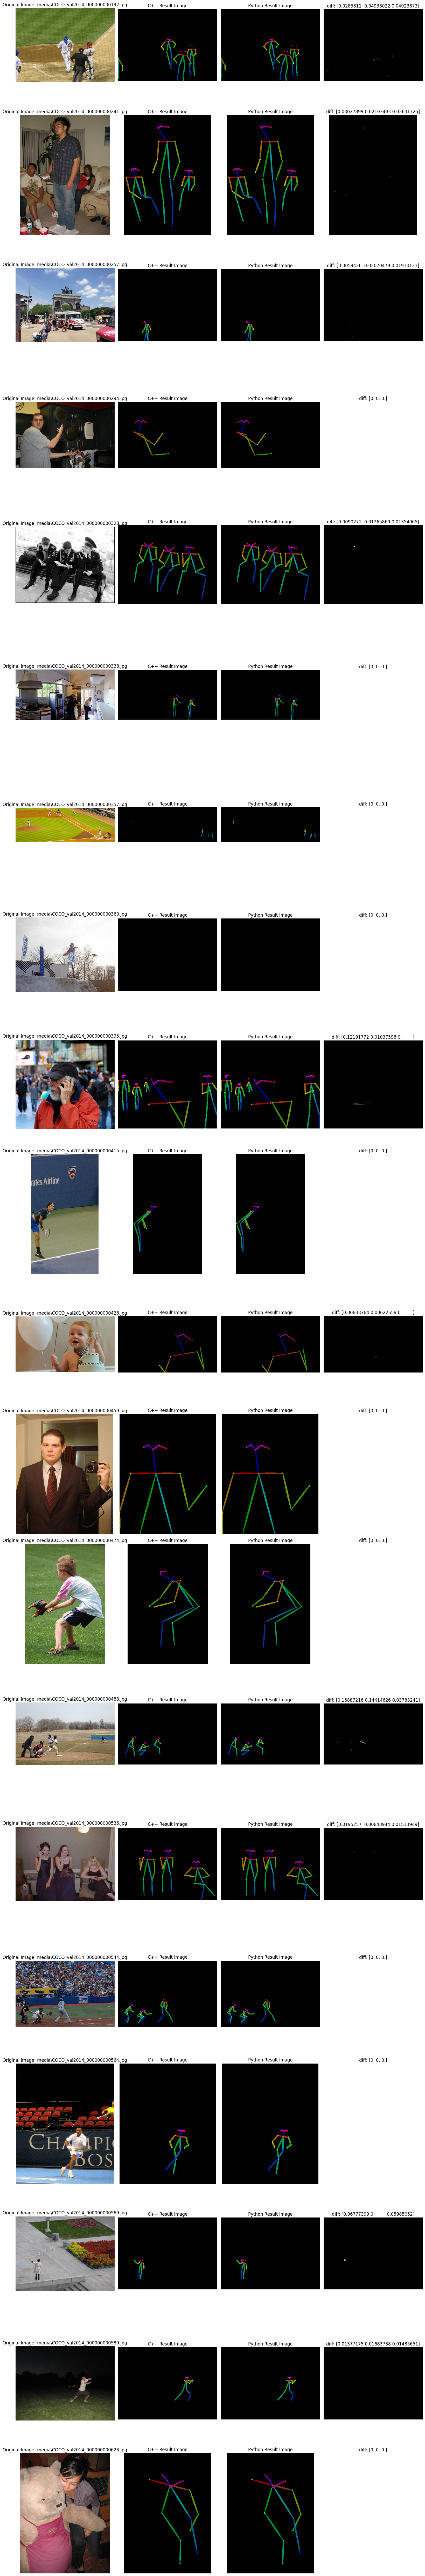

In [34]:
def display_images(data_list):
    num_images = len(data_list)
    fig, axes = plt.subplots(num_images, 4, figsize=(16, 5 * num_images))

    for i, data in enumerate(data_list):
        img = data["image"]
        cpp_result = data["cpp_result"]
        py_result = data["py_result"]
        input_file = data["file"]
        
        if num_images == 1:
            ax = axes
        else:
            ax = axes[i]
        
        # Display original image
        ax[0].imshow(img)
        ax[0].set_title("Original Image: " + input_file)
        ax[0].axis('off')
        
        # Display C++ result image
        ax[1].imshow(cpp_result)
        ax[1].set_title("C++ Result Image")
        ax[1].axis('off')
        
        # Display Python result image
        ax[2].imshow(py_result)
        ax[2].set_title("Python Result Image")
        ax[2].axis('off')

        # Display diff
        channel_diffs, total_diff = diff_image(cpp_result, py_result)
        ax[3].imshow(total_diff, cmap='gray')
        ax[3].set_title(f"diff: {channel_diffs}")
        ax[3].axis('off')

    plt.tight_layout()
    plt.show()

display_images(results)